In [1]:
import numpy as np
import pandas as pd
import re, os, sys, glob
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import itertools

import warnings
warnings.simplefilter(action='ignore', category=Warning)

%config Completer.use_jedi = False
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
pd.set_option('display.max_colwidth', 50)  # or 199

In [2]:
print(matplotlib.matplotlib_fname())

/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/matplotlibrc


In [3]:
prop = fm.FontProperties(fname=os.path.join(rcParams["datapath"], "fonts/ttf/Helvetica.ttf"))
plt.rcParams['font.family'] = prop.get_name()
print (plt.rcParams['font.family'])

['Helvetica']


In [ ]:
# unit conversion
inch2cm = 2.54
lb2kg = 0.453592

In [ ]:
TABULAR_CE = {'height':[226707, 226730], # cm: 226730, 226707
              'weight':[226531, 224639, 226512], # kg: 224639, 226512, lb: 226531
              'gcs_eye':[220739],
              'gcs_motor': [223901]# 20739-eye opening, 
              #223900-verbal response 223901-motor response->합산필요
             }

In [ ]:
init_samples = pd.read_csv('samples_mimic4_planB.csv', low_memory=False)
init_samples['intime'] = pd.to_datetime(init_samples['intime'])
init_samples['intubtime'] = pd.to_datetime(init_samples['intubtime'])
init_samples = init_samples.sort_values(by='intime').drop_duplicates(subset=['subject_id', 'hadm_id'], keep='first')
print(init_samples.shape)
init_samples.head()

### The height, weight, and GCS are collected with matching the SUBJECT_ID, HADM_ID, and ICUSTAY_ID of our study samples

#### CHARTEVENTS.csv

In [ ]:
def preprocess(chunk) :
    # convert dictionary values to a list
    tabular_ce_itemids = [ item for elem in list(TABULAR_CE.values()) for item in elem]
    sample = chunk[chunk['itemid'].isin(tabular_ce_itemids)]
    sample = sample[(sample['subject_id'].isin(init_samples['subject_id'])) &\
                   (sample['hadm_id'].isin(init_samples['hadm_id'])) &\
                   (sample['stay_id'].isin(init_samples['stay_id']))]
    return sample

In [ ]:
chunk_size = 10**4
list_of_samples = []
for cnt, chunk in enumerate(pd.read_csv('../1.0/icu/chartevents.csv', 
                                        chunksize=chunk_size, low_memory=False)) :
    sample = preprocess(chunk)
    list_of_samples.append(sample)

sample_ce = pd.concat(list_of_samples)

#### PROCEDUREEVENTS.csv

In [ ]:
# procedure_event = pd.read_csv('../1.0/icu/procedureevents.csv', low_memory=False)
# tmp = procedure_event[procedure_event['itemid']\
#                       .isin(list(itertools.chain(*list(TABULAR_CE.values()))))]
# sample_pe = tmp[(tmp['subject_id'].isin(init_samples['subject_id'])) &\
#                 (tmp['hadm_id'].isin(init_samples['hadm_id'])) &\
#                 (tmp['stay_id'].isin(init_samples['stay_id']))]

#### Weight, Height, GCS 정보는 CHARTEVENT안에만 존재한다. 

In [ ]:
def get_height(x) :
    if x['itemid'] == 226730 : # cm
        return x['valuenum']
    else :
        try :
            return x['valuenum'] * inch2cm # inch
        except TypeError :
            return float(x['valuenum']) * inch2cm
    
def get_weight(x) :
    if x['itemid'] == 226531 : # lb
        try :
            return x['valuenum'] * lb2kg
        except :
            return float(x['valuenum']) * lb2kg
    else :
        return x['valuenum']

In [ ]:
sample_ce['charttime'] = pd.to_datetime(sample_ce['charttime'])
chartdata = pd.DataFrame(columns=init_samples.columns.tolist() + \
                                 ['height', 'height_label', 'weight', 'weight_label', 
                                  'gcs_eye', 'gcs_eye_label', 'gcs_motor', 'gcs_motor_label'])

for i, row in tqdm(init_samples.iterrows(), total=init_samples.shape[0]) :

    # matching CHARTEVENTS with an indivual sample
    _sample_ce = sample_ce[(sample_ce['subject_id']==row['subject_id']) &\
                           (sample_ce['hadm_id']==row['hadm_id']) & \
                           (sample_ce['stay_id']==row['stay_id'])]

    
    # (ICU입실 직전 24시간부터 입실이후 24시간 동안) 자료의 시작과 종료시각 찾기
    collect_endtime = row['intubtime'] + pd.Timedelta(24, 'H')
    collect_starttime = row['intubtime'] - pd.Timedelta(24, 'H')
 
   # height (in CHARTEVENTS)
    height = _sample_ce[(_sample_ce['itemid'].isin(TABULAR_CE['height'])) &\
                        (_sample_ce['charttime']<=collect_endtime)&\
                        (_sample_ce['charttime']>=collect_starttime)]
    height['deltahours'] = (height['charttime'] - row['intubtime']) / pd.Timedelta(1, 'H')
    
    # Between 24 hours before intubation and intubation moment
    if height[height['deltahours']<0].shape[0] > 0 :
        _height = get_height(height[height['deltahours']<0].sort_values(by='deltahours', ascending=False)\
                                                               .iloc[0][['itemid', 'valuenum']])
        _height_label = 1
    # Between intubation moment and 24 hours after intubation 
    elif height[height['deltahours']>=0].shape[0] > 0 :
        _height = get_height(height[height['deltahours']>=0]\
                                .sort_values(by='deltahours').iloc[0][['itemid', 'valuenum']])
        _height_label = 0
    else :
        _height = np.nan
        _height_label = np.nan
    
    if _height > 250 : 
        _height = np.nan
        _height_label = np.nan
     
                                  
    # weight (in CHARTEVENTS)
    weight = _sample_ce[(_sample_ce['itemid'].isin(TABULAR_CE['weight'])) &\
                        (_sample_ce['charttime']<=collect_endtime)&\
                        (_sample_ce['charttime']>=collect_starttime)]
    weight['deltahours'] = (weight['charttime'] - row['intime']) / pd.Timedelta(1, 'H')
                                  
    # Between 24 hours before intubation and intubation moment
    if weight[weight['deltahours']<0].shape[0] > 0 :
        _weight = get_weight(weight[weight['deltahours']<0]\
                                 .sort_values(by='deltahours', ascending=False).iloc[0][['itemid', 'valuenum']])
        _weight_label = 1
    # Between intubation moment and 24 hours after intubation 
    elif weight[weight['deltahours']>=0].shape[0] > 0 :
        _weight = get_weight(weight[weight['deltahours']>=0]\
                                .sort_values(by='deltahours').iloc[0][['itemid', 'valuenum']])
        _weight_label = 0
    else :
        _weight = np.nan
        _weight_label = np.nan
        
    if _weight > 380 :
        _weight = np.nan
        _weight_label = np.nan

        
    # Glasgow Coma Scale Eye
    gcs_eye = _sample_ce[(_sample_ce['itemid'].isin(TABULAR_CE['gcs_eye'])) &\
                         (_sample_ce['charttime']<=collect_endtime)&\
                         (_sample_ce['charttime']>=collect_starttime)]
    gcs_eye['deltahours'] = (gcs_eye['charttime'] - row['intime']) / pd.Timedelta(1, 'H')
                                  
    # Between 24 hours before intubation and intubation moment
    if gcs_eye[gcs_eye['deltahours']<0].shape[0] > 0:
        _gcs_eye = gcs_eye[gcs_eye['deltahours']<0]\
                       .sort_values(by='deltahours', ascending=False).iloc[0]['valuenum']
        _gcs_eye_label = 1
        
    # Between intubation moment and 24 hours after intubation 
    elif gcs_eye[gcs_eye['deltahours']>=0].shape[0] > 0 :
        _gcs_eye = gcs_eye[gcs_eye['deltahours']>=0].sort_values(by='deltahours').iloc[0]['valuenum']
        _gcs_eye_label = 0
        
    else :
        _gcs_eye = np.nan
        _gcs_eye_label = np.nan
    

    # Glasgow Coma Scale Motor
    gcs_motor = _sample_ce[(_sample_ce['itemid'].isin(TABULAR_CE['gcs_motor'])) &\
                         (_sample_ce['charttime']<=collect_endtime)&\
                         (_sample_ce['charttime']>=collect_starttime)]
    gcs_motor['deltahours'] = (gcs_motor['charttime'] - row['intime']) / pd.Timedelta(1, 'H')
                                  
    # Between 24 hours before intubation and intubation moment
    if gcs_motor[gcs_motor['deltahours']<0].shape[0] > 0:
        _gcs_motor = gcs_motor[gcs_motor['deltahours']<0]\
                       .sort_values(by='deltahours', ascending=False).iloc[0]['valuenum']
        _gcs_motor_label = 1
        
    # Between intubation moment and 24 hours after intubation 
    elif gcs_motor[gcs_motor['deltahours']>=0].shape[0] > 0:
        _gcs_motor = gcs_motor[gcs_motor['deltahours']>=0].sort_values(by='deltahours').iloc[0]['valuenum']
        _gcs_motor_label = 0
        
    else :
        _gcs_motor = np.nan
        _gcs_motor_label = np.nan
        
    chartdata.loc[len(chartdata)] = row.tolist() + [_height, _height_label, _weight, _weight_label, 
                                                    _gcs_eye, _gcs_eye_label, _gcs_motor, _gcs_motor_label]

In [ ]:
print('height missing number', chartdata[chartdata['height'].isnull()].shape, "\n", 
      'weight missing number', chartdata[chartdata['weight'].isnull()].shape, "\n",
      'gcs_eye missing number', chartdata[chartdata['gcs_eye'].isnull()].shape, "\n",
      'gcs_motor missing number', chartdata[chartdata['gcs_motor'].isnull()].shape)

In [ ]:
display(chartdata['height_label'].value_counts())
display(chartdata['weight_label'].value_counts())
display(chartdata['gcs_eye_label'].value_counts())
display(chartdata['gcs_motor_label'].value_counts())

### Distribution of Height, Weight, and Glasgow Coma Scale

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7))
ax = axes.flatten()
units = {'height':'cm', 'weight':'kg', 'gcs_eye':'score', 'gcs_motor':'score'}
for i, var in enumerate(['height', 'weight', 'gcs_eye', 'gcs_motor']) :
    legend_str = 'missing ratio: {0:0.1f}%'.format(chartdata[chartdata[var].isnull()].shape[0]/chartdata.shape[0]*100)
    chartdata[var].dropna().hist(bins=20, ax=ax[i], color='k', label=legend_str)
    ax[i].set_xlabel(str(var).upper() + ' ('+units[var]+')', fontsize=13)
    ax[i].set_ylabel('Counts', fontsize=13)
    ax[i].set_yscale('log')
    ax[i].legend(fontsize=12)
    ax[i].tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()

### Lab data

In [ ]:
TIME_SERIES_LE = {
                  'Hemoglobin': [50811, 51222], 
                  'pH': [50820, 50831], 
                  'Lactate': [50813, 52442], 
                  'Albumin': [50862, 51542], 
                  'Anion_gap': [50868, 52500],
                  'Bicarbonate': [50882, 50803],
                  'Bilirubin': [50885], # 50883+50884 = 50885
                  'BUN': [51006, 52647],
                  'Creatinine': [50912, 52546],
                  'Lymphocytes': [51244],
                  'Neutrophils': [51256],
                  'Platelets': [51265],
                  'Prothrombin_time_inr': [51237], # 결측값 많을시  :INR (51274 52921)   
                  'Sodium': [50983, 52623],
                  'Potassium': [50971, 52610],
                  'WBC': [51300, 51301 ]
                 }

In [ ]:
DATA_LIMITS = {
              'Hemoglobin': [0, 18], 
              'pH': [6.5, 8], 
              'Lactate': [0, 15], 
              'Albumin': [0.1, 6], 
              'Anion_gap': [0.1, 40],
              'Bilirubin': [0.1, 50], 
              'Bicarbonate': [0.1, 50], 
              'BUN':[0.1, 200], 
              'Creatinine': [0.1, 20], 
              'Lymphocytes': [0, 100],
              'Neutrophils': [0, 100],
              'Platelets': [0.1, 1000], 
              'Prothrombin_time_inr':[0.1, 15], 
              'NL_RATIO': [0.1, 100], 
              'Sodium': [110, 190],
              'Potassium': [2, 10],
              'WBC': [0, 100]
              }

In [ ]:
def preprocess(chunk) :
    # convert dictionary values to a list
    ts_le_itemids = [item for elem in list(TIME_SERIES_LE.values()) for item in elem]
    sample = chunk[chunk['itemid'].isin(ts_le_itemids)]
    sample = sample[(sample['subject_id'].isin(init_samples['subject_id'])) &\
                   (sample['hadm_id'].isin(init_samples['hadm_id']))]
    return sample


chunk_size = 10**4
list_of_samples = []
for cnt, chunk in enumerate(pd.read_csv('../1.0/hosp/labevents.csv.gz', 
                                        chunksize=chunk_size, low_memory=False)) :
    sample = preprocess(chunk)
    list_of_samples.append(sample)

sample_le = pd.concat(list_of_samples)

In [ ]:
sample_le.head()

In [ ]:
def windowing(df) :
    for i, col in enumerate(list(DATA_LIMITS.keys())) :
        lower_limit, upper_limit = DATA_LIMITS[col]
        df.loc[:, col] = df.loc[:, col].apply(lambda x: lower_limit if x < lower_limit \
                                                                    else (upper_limit if x > upper_limit \
                                                                                      else x))
    return df

In [ ]:
sample_le['charttime'] = pd.to_datetime(sample_le['charttime'])
# plt.rcParams["figure.figsize"] = (14,4)
df_representative_features = pd.DataFrame()
for i, row in tqdm(init_samples.iterrows(), total=init_samples.shape[0]) :
    out_dict = {'subject_id':row['subject_id'], 'hadm_id':row['hadm_id']}

    _sample_le = sample_le[(sample_le['subject_id']==row['subject_id']) &\
                           (sample_le['hadm_id']==row['hadm_id'])]

    try : 
        _sample_le.loc[:, 'valuenum'] = _sample_le.loc[:, 'valuenum']\
                                            .str.extract('(\d+)', expand=False).astype(float)
    except :
        _sample_le.loc[:, 'valuenum'] = _sample_le.loc[:, 'valuenum'].astype(float)
    
    # (ICU입실 직전 24시간부터 입실이후 24시간 동안) 자료의 시작과 종료시각 찾기
    collect_endtime = row['intubtime'] + pd.Timedelta(24, 'H')
    collect_starttime = row['intubtime'] - pd.Timedelta(24, 'H')
    
    # query and interpolate time series explanatory variables one at a time
    for j, var in enumerate(list(TIME_SERIES_LE.keys())) :

        # LABEVNETS
        var_le = _sample_le.loc[(_sample_le['charttime']>=collect_starttime) &\
                                (_sample_le['charttime']<collect_endtime) & \
                                (_sample_le['itemid'].isin(TIME_SERIES_LE[var]))]\
                     .loc[:, ('charttime', 'valuenum')]
        
        var_le['deltahours'] = (var_le['charttime'] - row['intubtime']) / pd.Timedelta(1, 'H')
                                  
        # Between 24 hours before ICU and ICU in
        if var_le[var_le['deltahours']<0].shape[0] > 0 :
            _var = var_le[var_le['deltahours']<0]\
                         .sort_values(by='deltahours', ascending=False).iloc[0]['valuenum']
            _var_label = 1
        # Between ICU in and 24 hours after ICU
        elif var_le[var_le['deltahours']>=0].shape[0] > 0 :
            _var = var_le[var_le['deltahours']>=0]\
                         .sort_values(by='deltahours').iloc[0]['valuenum']
            _var_label = 0
        else :
            _var = np.nan
            _var_label = np.nan

        # check _var within range from min to max

        if _var > DATA_LIMITS[var][1] :
            _var = DATA_LIMITS[var][1]
        elif _var < DATA_LIMITS[var][0] :
            _var = DATA_LIMITS[var][0]
        var_name_label = var+'_label'
        out_dict[var] = _var
        out_dict[var_name_label] = _var_label
#     print(out_dict)
    individual_representative = pd.Series(out_dict)
    if df_representative_features.empty :
        df_representative_features = individual_representative.to_frame().T.copy()
    else :
        df_representative_features = pd.concat([df_representative_features, 
                                                individual_representative.to_frame().T], 
                                               ignore_index=True)
    
              
    df_representative_features['NL_RATIO'] = \
        df_representative_features.apply(lambda x: 100 if x['Lymphocytes']<=0 \
                                                       else x['Neutrophils']/x['Lymphocytes'], axis=1)
        
    df_representative_features = windowing(df_representative_features)

print(df_representative_features.shape)
df_representative_features.head()    
    

In [ ]:
# df_representative_features.drop(columns=['Lymphocytes', 'Neutrophils'], inplace=True)
table = pd.merge(chartdata, df_representative_features, on=['subject_id', 'hadm_id'], how='left')

### Admission type

In [ ]:
admission_types = pd.read_csv('downloaded_BigQuery/sapsii_admissiontype_score.csv')
admission_types.head()

In [ ]:
table = pd.merge(table, admission_types.rename(columns={'starttime':'adm_starttime'}),
                 on=['subject_id', 'hadm_id', 'stay_id'], how='left')
table.head()

### Merging careunit category

In [ ]:
transfer = pd.read_csv('../1.0/core/transfers.csv.gz')
transfer['careunit'].value_counts()

In [ ]:
transfer = pd.read_csv('../1.0/core/transfers.csv.gz')
transfer['intime'] = pd.to_datetime(transfer['intime'])
table = pd.merge(table, transfer, on=['subject_id', 'hadm_id', 'intime'], how='left')
# table.drop(columns=['Unnamed: 0', 'outtime_y'], inplace=True)
table[table['careunit'].isnull()].shape

In [ ]:
careunit_class = pd.read_excel('careunit_classification.xlsx', engine='openpyxl')
careunit_class['category'] = careunit_class['category'].interpolate(method='pad')
table = pd.merge(table, careunit_class, left_on='careunit', right_on='Unit')\
            .rename(columns={'category':'careunit_penta'})
table.head()

### Merging temperature

In [ ]:
temperatures = pd.read_csv('downloaded_BigQuery/oasis_temp_urineoutput.csv')
table = pd.merge(table, temperatures, on=['subject_id', 'hadm_id', 'stay_id'], how='left')
table.head()

### Merging sex

In [ ]:
patients = pd.read_csv('../1.0/core/patients.csv.gz', compression='gzip', low_memory=False)
tabular = pd.merge(table, patients.loc[:, ('subject_id', 'gender')].rename(columns={'gender':'sex'}), 
                   on = 'subject_id', how='left')
tabular['sex'].value_counts()

### merging SOFA and SAPSII scores

In [ ]:
sofa = pd.read_csv('./sofa_stayid_planB_bq-results-20220507.csv.gz', compression='gzip')
sofa['endtime'] = pd.to_datetime(sofa['endtime'])
sapsii = pd.read_csv('./sapsii_subject_id_hadm_id_20220507.csv')
sapsii['endtime'] = pd.to_datetime(sapsii['endtime'])
display(sofa.head())
display(sapsii)

In [ ]:
def get_value_and_label(_df, column_name) :
    if _df[(_df['delta_hrs']<=0)&(_df['delta_hrs']>-24)].shape[0] > 0 :
        _df_score = _df[(_df['delta_hrs']<=0)&(_df['delta_hrs']>-24)]\
                           .sort_values(by=['delta_hrs'], ascending=False)[column_name].iloc[0]
        _df_label = 1
    
    # get the nearest _df score since intubation 
    elif _df[(_df['delta_hrs']>0)&(_df['delta_hrs']<=24)].shape[0] > 0 :
        _df_score = _df[(_df['delta_hrs']>0)&(_df['delta_hrs']<=24)]\
                           .sort_values(by=['delta_hrs'])[column_name].iloc[0]
        _df_label = 0
    # get the nearest _df score before (intubation - 24hours)
#     elif _df[_df['delta_hrs']<=-24].shape[0] > 0 :
#         _df_score = _df[_df['delta_hrs']<=-24].sort_values(by=['delta_hrs'], ascending=False)[column_name].iloc[0]
#         _df_label = 2
    # get the nearest _df score since (intubation + 24hours)
#     elif _df[_df['delta_hrs']>24].shape[0] > 0 :
#         _df_score = _df[_df['delta_hrs']>24].sort_values(by=['delta_hrs'])[column_name].iloc[0]
#         _df_label = -1
    # _df
    else :
        _df_score = np.nan
        _df_label = np.nan
        
    return _df_score, _df_label
    

    
sapsii_sofa = pd.DataFrame(columns=['subject_id', 'hadm_id', 'stay_id', 
                                    'sapsii', 'sapsii_label', 'sofa', 'sofa_label'])
for i, row in tabular.iterrows() :
    _sapsii = sapsii[(sapsii['subject_id']==row['subject_id'])&\
                     (sapsii['hadm_id']==row['hadm_id'])&\
                     (sapsii['stay_id']==row['stay_id'])][['starttime', 'endtime', 'sapsii']]\
                  .sort_values(by='endtime')
    _sofa = sofa[(sofa['subject_id']==row['subject_id'])&\
                 (sofa['hadm_id']==row['hadm_id'])&\
                 (sofa['stay_id']==row['stay_id'])][['starttime', 'endtime', 'sofa_24hours']]\
                .sort_values(by='endtime')
    
    # sapsii
    _sapsii['delta_hrs'] = _sapsii['endtime'].apply(lambda x: (x-row['intubtime'])/pd.Timedelta(1, unit='h'))
    # get the nearest sapsii score before intubation 
    if _sapsii.shape[0] > 0 :
        _sapsii_score, _sapsii_label = get_value_and_label(_sapsii, 'sapsii')
    else :
        _sapsii_score, _sapsii_label = np.nan, np.nan

    # sofa
    _sofa['delta_hrs'] = _sofa['endtime'].apply(lambda x: (x-row['intubtime'])/pd.Timedelta(1, unit='h'))
    if _sofa.shape[0] > 0 :
        _sofa_score, _sofa_label = get_value_and_label(_sofa, 'sofa_24hours')
    else :
        _sofa_score, _sofa_label = np.nan, np.nan
    sapsii_sofa.loc[len(sapsii_sofa)] = [row['subject_id'], row['hadm_id'], row['stay_id'], 
                                         _sapsii_score, _sapsii_label, _sofa_score, _sofa_label]

sapsii_sofa

In [ ]:
print(sapsii_sofa[sapsii_sofa['sapsii_label'].isnull()].shape, sapsii_sofa[sapsii_sofa['sofa_label'].isnull()].shape)
display(sapsii_sofa['sapsii_label'].value_counts())
sapsii_sofa['sofa_label'].value_counts()

In [ ]:
tabular

In [ ]:
print(tabular.shape)
tabular = pd.merge(tabular.drop(columns=['outtime_y']).rename(columns={'outtime_x':'outtime'}), 
                   sapsii_sofa, on=['subject_id', 'hadm_id', 'stay_id'], how='left')

In [ ]:
tabular

In [ ]:
display(tabular['OUTCLASS2'].value_counts())
display(tabular[(tabular['sapsii'].notnull())&(tabular['sofa'].notnull())]['OUTCLASS2'].value_counts())
tabular = tabular[(tabular['sapsii'].notnull())&(tabular['sofa'].notnull())]

In [ ]:
tabular.shape

### Socioeconomic features editting

In [ ]:
# Insurance binarizing
display(tabular['insurance'].value_counts())
tabular['insurance_bin'] = tabular['insurance'].apply(lambda x: 'Public' if x=='Medicare' or \
                                                                            x=='Medicaid' 
                                                                         else 'Other')
tabular['insurance_bin'].value_counts()

In [ ]:
# Language binarizing
display(tabular['language'].value_counts())
tabular['language_bin'] = tabular['language'].apply(lambda x: 'English' if x=='ENGLISH' 
                                                                         else 'Other')
tabular['language_bin'].value_counts()

In [ ]:
# Marital status binarizing
display(tabular['marital_status'].value_counts())
tabular['marital_status_bin'] = tabular['marital_status'].apply(lambda x: 'Couple' if x=='MARRIED' 
                                                                         else 'Single')
tabular['marital_status_bin'].value_counts()

In [ ]:
# Ethnicity
def ETHNICITY2PENTAGRAM(x) :
    if re.search(r'white', x, re.IGNORECASE) :
        return 'White'
    elif re.search(r'black', x, re.IGNORECASE) :
        return 'Black'
    elif re.search(r'asian', x, re.IGNORECASE) :
        return 'Asian'
    elif re.search(r'hispanic', x, re.IGNORECASE) :
        return 'Hispanic'
    elif re.search(r'UNKNOWN|UNABLE', x, re.IGNORECASE) :
        return None
    else :
        return 'Others'

display(tabular['ethnicity'].value_counts())
tabular['ethnicity_penta'] = tabular['ethnicity'].apply(ETHNICITY2PENTAGRAM)
tabular['ethnicity_penta'].value_counts()

In [ ]:
comorbidity = pd.read_csv('planB_charlson_score.csv')
tabular_morbidities = pd.merge(tabular, comorbidity, on=['subject_id', 'hadm_id', 'stay_id'], how='left')
tabular_morbidities = tabular_morbidities.sort_values(by='intime')\
                                             .drop_duplicates(subset=['subject_id', 'hadm_id'], keep='first')

In [ ]:
print(tabular_morbidities.shape)
tabular_morbidities.head()

In [ ]:
columns_label = [x for x in tabular_morbidities.columns.tolist() if re.search(r'_label', x)]
fig = plt.figure(figsize=(18, 12))
fig.patch.set_facecolor('white')
nrows, ncols = 6, 4
label_data = tabular_morbidities.loc[:, columns_label]
for i, col in enumerate(label_data.columns) :
    legend_str = 'missing ratio: {0:0.2f}%'\
                    .format(label_data[label_data[col].isnull()].shape[0]/label_data.shape[0]*100)
    ax = fig.add_subplot(nrows, ncols, i+1)
    if label_data[col].dtype == object :
        sns.countplot(label_data[col].astype('category'), ax=ax, color='k', label=legend_str)
    else :
        ax.hist(label_data[col], bins=20, color='k', label=legend_str)
    ax.set_xlabel(col, fontsize=13)
    ax.set_ylabel('N', fontsize=13)
    ax.set_xlabel(str(col).upper(), fontsize=13)
    ax.set_ylabel('Counts', fontsize=13)
    ax.legend(fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
plt.savefig('planB_tabular_variables_label_dist.png')

In [ ]:
print(tabular_morbidities.shape)
tabular_morbidities.sort_values(by=['subject_id', 'intubtime']).drop_duplicates(subset=['subject_id']).shape

In [ ]:
display(tabular_morbidities.head())
tabular_morbidities.rename(columns = {'temp':'T'})\
                        .loc[:, ('subject_id', 'hadm_id', 'stay_id', 'intub_duration', 'mortality14', 'OUTCLASS2', 
                                 'age', 'sex', 'height', 'weight', 'gcs_eye', 'gcs_motor',
                                 'Hemoglobin', 'pH', 'Lactate', 'Albumin', 'Anion_gap', 'Bilirubin', 
                                 'Bicarbonate', 'BUN', 'Creatinine', 'Platelets', 'Prothrombin_time_inr',
                                 'NL_RATIO', 'Sodium', 'Potassium', 'WBC', 'T', 'admissiontype_score', 
                                 'insurance_bin', 'language_bin', 'marital_status_bin',
                                 'ethnicity_penta', 'careunit_penta', 'myocardial_infarct', 
                                 'congestive_heart_failure',
                                 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia',
                                 'chronic_pulmonary_disease', 'rheumatic_disease',
                                 'peptic_ulcer_disease', 'mild_liver_disease', 'diabetes_without_cc',
                                 'diabetes_with_cc', 'paraplegia', 'renal_disease', 'malignant_cancer',
                                 'severe_liver_disease', 'metastatic_solid_tumor', 'aids', 
                                 'sapsii', 'sofa')]\
                         .to_csv('planB_tabular_mimic4.csv', index=False)

In [ ]:
# tabular_morbidities = pd.read_csv('planB_tabular_mimic4.csv')
# fig = plt.figure(figsize=(18, 21))
# fig.patch.set_facecolor('white')
# nrows, ncols = 12, 4
# tabular_data = tabular_morbidities\
#                         .loc[:, ('OUTCLASS2', 'age', 'sex', 'height', 'weight', 'gcs_eye', 'gcs_motor',
#                                  'Hemoglobin', 'pH', 'Lactate', 'Albumin', 'Anion_gap', 'Bilirubin', 
#                                  'Bicarbonate', 'BUN', 'Creatinine', 'Platelets', 'Prothrombin_time_inr',
#                                  'NL_RATIO', 'Sodium', 'Potassium', 'WBC', 'T', 'admissiontype_score', 
#                                  'insurance_bin', 'language_bin', 'marital_status_bin',
#                                  'ethnicity_penta', 'careunit_penta', 'myocardial_infarct', 
#                                  'congestive_heart_failure', 'sapsii', 'sofa',
#                                  'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia',
#                                  'chronic_pulmonary_disease', 'rheumatic_disease',
#                                  'peptic_ulcer_disease', 'mild_liver_disease', 'diabetes_without_cc',
#                                  'diabetes_with_cc', 'paraplegia', 'renal_disease', 'malignant_cancer',
#                                  'severe_liver_disease', 'metastatic_solid_tumor', 'aids')]
# tabular_data['weight'] = tabular_data['weight'].astype(float)
# tabular_data['height'] = tabular_data['height'].astype(float)
# for i, col in enumerate(tabular_data.columns) :
#     legend_str = 'missing ratio: {0:0.2f}%'\
#                     .format(tabular_data[tabular_data[col].isnull()].shape[0]/tabular_data.shape[0]*100)
#     ax = fig.add_subplot(nrows, ncols, i+1)
#     if tabular_data[col].dtype == object :
#         sns.countplot(tabular_data[col].astype('category'), ax=ax, color='k', label=legend_str)
#     else :
#         ax.hist(tabular_data[col], bins=20, color='k', label=legend_str)
#     ax.set_xlabel(col, fontsize=12)
#     ax.set_ylabel('N', fontsize=12)
#     ax.set_xlabel(str(col).upper(), fontsize=12)
#     ax.set_ylabel('Counts', fontsize=12)
#     ax.legend(fontsize=12)
#     if col == 'ETHNICITY_PENTA' : 
#         ax.tick_params(axis='x', which='major', labelsize=12, rotation=30)
#     ax.tick_params(axis='both', which='major', labelsize=12)
# plt.tight_layout()
# pp = PdfPages('Figures/Histogram.pdf')
# pp.savefig(fig)
# pp.close()

In [4]:
tabular_morbidities = pd.read_csv('planB_tabular_mimic4.csv', low_memory=False)\
                          .rename(columns={'OUTCLASS2':'Successful weaning within 2 weeks', 
                                           'age':'Age', 
                                           'sex':'Sex', 
                                           'height':'Height', 'weight':'Weight', 
                                           'gcs_eye':'GCS score (eye)', 'gcs_motor':'GCS score (motor)',
                                           'Anion_gap':'Anion gap', 
                                           'Bilirubin':'Total bilirubin', 
                                           'Platelets':'Platelet count', 
                                           'Prothrombin_time_inr':'Prothrombin time',
                                           'NL_RATIO':'Neutrophil/lymphocyte ratio', 'WBC':'WBC count', 
                                           'T':'Body temperature', 
                                           'admissiontype_score':'Type of admission', 
                                           'insurance_bin':'Type of insurance', 
                                           'language_bin':'Primary language',
                                           'marital_status_bin':'Marital status',
                                           'ethnicity_penta':'Ethnicity', 'careunit_penta':'Type of ICU',
                                           'myocardial_infarct':'Myocardial infarction',
                                           'congestive_heart_failure':'Congestive heart failure',
                                           'peripheral_vascular_disease':'Peripheral vascular disease',
                                           'cerebrovascular_disease':'Cerebrovascular disease',
                                           'dementia':'Dementia', 
                                           'chronic_pulmonary_disease':'Chronic pulmonary disease',
                                           'rheumatic_disease':'Rheumatic disease',
                                           'peptic_ulcer_disease':'Peptic ulcer disease',
                                           'mild_liver_disease':'Mild liver disease',
                                           'diabetes_without_cc':'Diabetes without complication/comorbidity',
                                           'diabetes_with_cc':'Diabetes with complication/comorbidity',
                                           'paraplegia':'Paraplegia', 'renal_disease':'Renal disease',
                                           'malignant_cancer':'Malignancy', 
                                           'severe_liver_disease':'Severe liver disease',
                                           'metastatic_solid_tumor':'Metastatic solid tumor',
                                           'aids':'AIDS', 'sapsii':'SAPSII', 'sofa':'SOFA'})


tabular_morbidities["Successful weaning within 2 weeks"].replace({0: "Yes", 1: "No"}, inplace=True)
tabular_morbidities['Type of admission'].replace({0:'Scheduled surgical', 6:'Medical', 
                                                  8:'Unscheduled surgical'}, inplace=True)

In [5]:
tabular_morbidities

,subject_id,hadm_id,stay_id,intub_duration,mortality14,Successful weaning within 2 weeks,Age,Sex,Height,Weight,GCS score (eye),GCS score (motor),Hemoglobin,pH,Lactate,Albumin,Anion gap,Total bilirubin,Bicarbonate,BUN,Creatinine,Platelet count,Prothrombin time,Neutrophil/lymphocyte ratio,Sodium,Potassium,WBC count,Body temperature,Type of admission,Type of insurance,Primary language,Marital status,Ethnicity,Type of ICU,Myocardial infarction,Congestive heart failure,Peripheral vascular disease,Cerebrovascular disease,Dementia,Chronic pulmonary disease,Rheumatic disease,Peptic ulcer disease,Mild liver disease,Diabetes without complication/comorbidity,Diabetes with complication/comorbidity,Paraplegia,Renal disease,Malignancy,Severe liver disease,Metastatic solid tumor,AIDS,SAPSII,SOFA
0,18106347,24305596,30588857,0.138889,0,Yes,48,F,166.37,96.20000,1.0,1.0,10.5,7.28,1.1,NaN,9.0,NaN,24.0,8.0,0.4,195.0,1.2,5.018987,140.0,4.1,15.4,35.80,Unscheduled surgical,Other,English,Single,White,Surgery,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.0,0.0
1,17195991,23542772,38319097,1.291667,0,Yes,61,F,NaN,110.00000,1.0,4.0,NaN,7.42,NaN,NaN,15.0,0.3,23.0,13.0,0.7,NaN,NaN,NaN,145.0,2.8,NaN,38.80,Medical,Other,English,Single,NaN,Surgery,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39.0,0.0
2,16284044,23864737,36817845,0.166667,0,Yes,61,F,170.18,98.00000,1.0,1.0,10.6,7.38,3.0,NaN,12.0,NaN,22.0,12.0,0.5,169.0,1.4,6.060150,136.0,4.0,13.5,37.00,Unscheduled surgical,Other,English,Single,White,Surgery,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44.0,0.0
3,13201095,28453791,39953418,5.708333,1,No,88,F,162.56,71.90000,3.0,3.0,15.0,7.40,4.4,NaN,23.0,1.0,24.0,46.0,2.1,214.0,2.6,12.219178,142.0,3.8,18.8,39.39,Medical,Public,English,Single,NaN,Medical,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,82.0,1.0
4,12770182,20446666,34901199,1.347917,0,Yes,53,M,177.80,119.00000,4.0,6.0,14.8,7.41,1.7,NaN,11.0,0.5,28.0,24.0,0.8,326.0,1.1,13.765625,142.0,4.2,15.8,38.50,Medical,Other,English,Couple,White,Medical,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23237,18001760,29994129,30222172,0.250000,0,Yes,58,M,180.34,96.30000,1.0,1.0,7.7,7.38,2.2,NaN,9.0,NaN,30.0,14.0,1.4,114.0,1.7,4.730769,138.0,4.4,8.0,35.60,Medical,Other,English,Couple,Black,Surgery,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,24.0,2.0
23238,12648465,22702738,32471162,18.003472,0,No,54,F,NaN,NaN,3.0,6.0,7.8,7.40,4.1,NaN,11.0,1.0,26.0,10.0,0.6,230.0,2.2,NaN,144.0,3.3,8.3,37.61,Medical,Public,English,Single,Black,Surgery,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,27.0,5.0
23239,16554888,29815513,33463387,0.881944,0,Yes,67,F,NaN,74.84268,4.0,6.0,9.5,7.44,3.2,NaN,14.0,0.6,24.0,40.0,1.1,63.0,1.6,12.458333,137.0,4.8,10.8,34.40,Medical,Public,English,Single,Black,Medical,1,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,40.0,3.0
23240,19815165,23465980,31378173,3.818056,0,Yes,79,F,147.32,65.60000,1.0,1.0,9.6,7.20,7.9,NaN,16.0,NaN,14.0,13.0,0.8,43.0,1.8,6.547619,142.0,4.8,11.1,33.60,Unscheduled surgical,Other,Other,Single,Hispanic,Surgery,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45.0,7.0


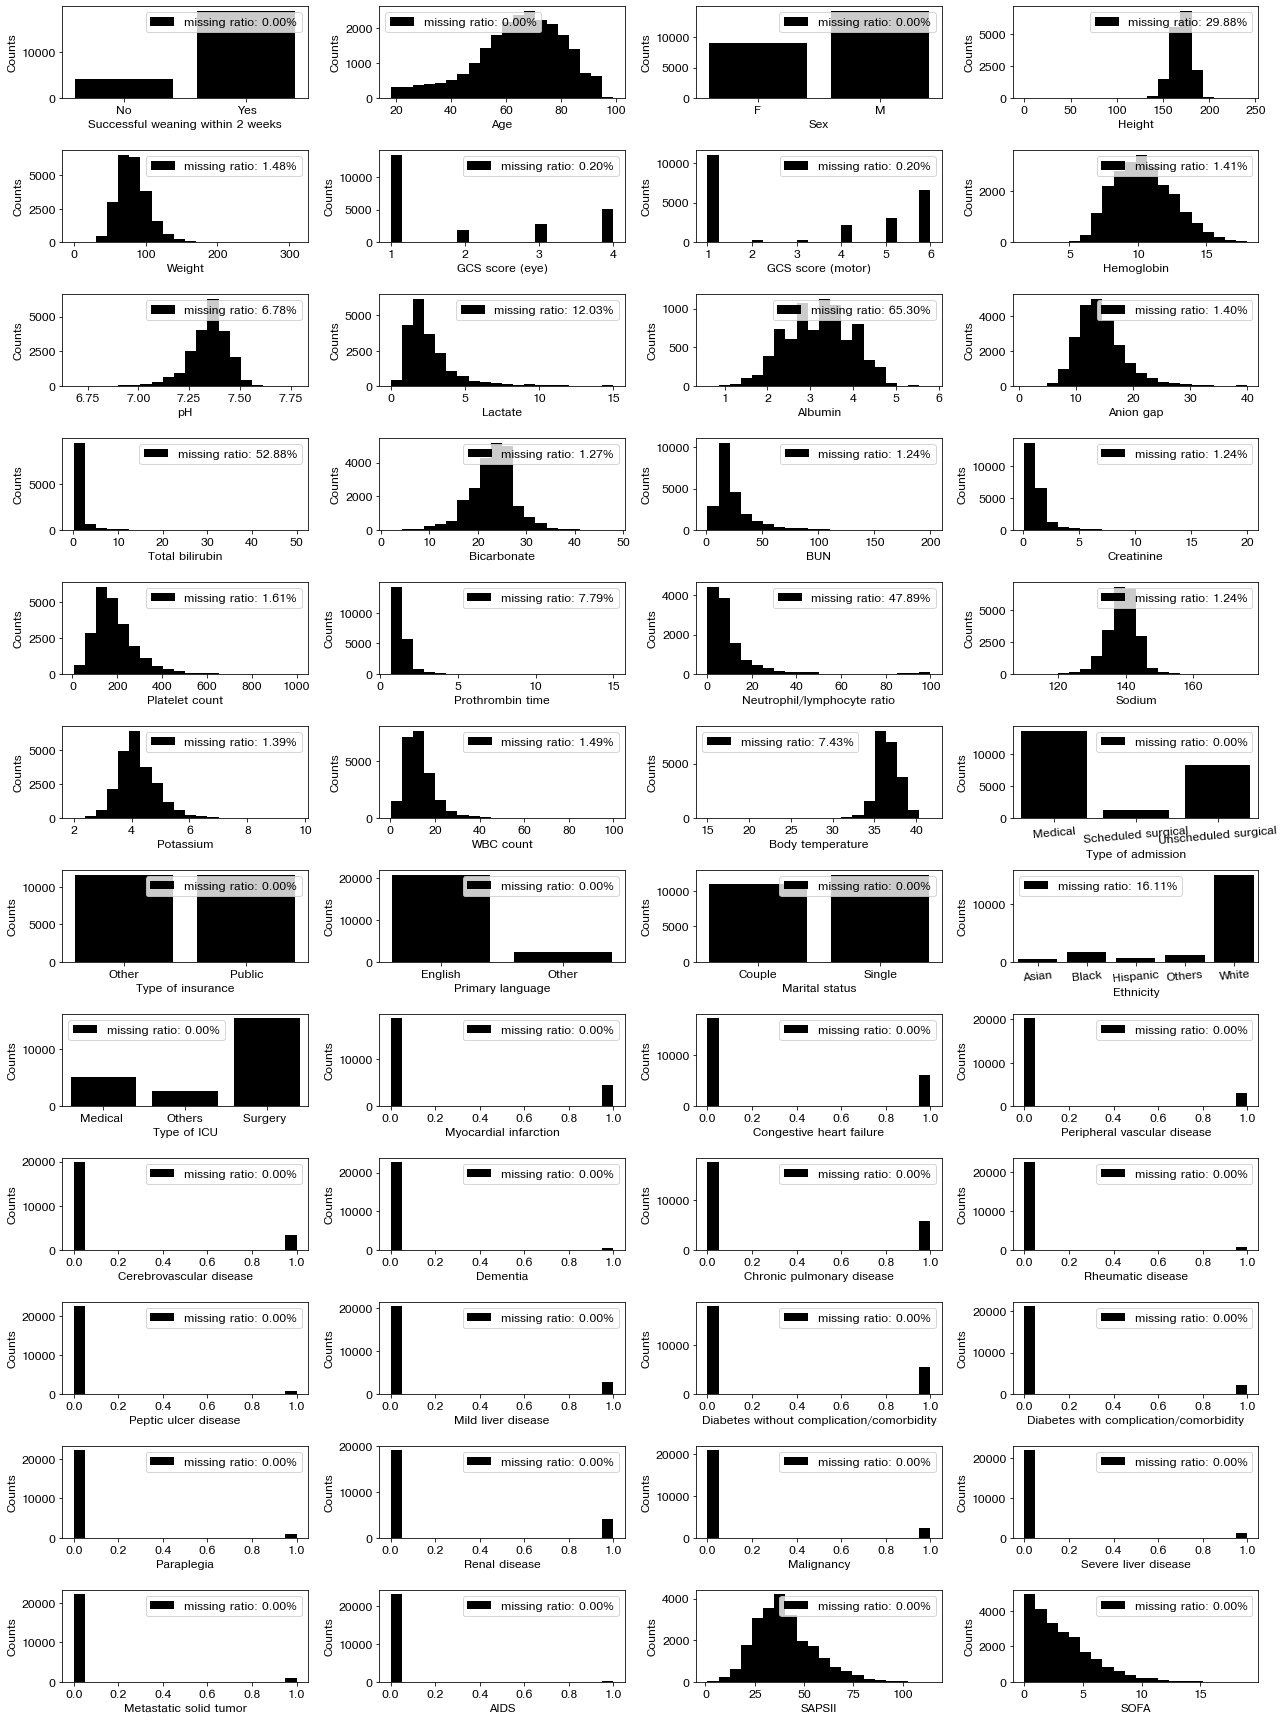

In [6]:
fig = plt.figure(figsize=(18, 24))
fig.patch.set_facecolor('white')
nrows, ncols = 12, 4
tabular_data = tabular_morbidities.loc[:, ('Successful weaning within 2 weeks', 
                                           'Age', 'Sex', 'Height', 'Weight', 'GCS score (eye)', 
                                           'GCS score (motor)', 'Hemoglobin', 'pH', 'Lactate', 
                                           'Albumin', 'Anion gap', 'Total bilirubin', 'Bicarbonate', 
                                           'BUN', 'Creatinine', 'Platelet count', 
                                           'Prothrombin time', 'Neutrophil/lymphocyte ratio', 
                                           'Sodium', 'Potassium', 'WBC count', 'Body temperature',
                                           'Type of admission', 'Type of insurance', 'Primary language',
                                           'Marital status', 'Ethnicity', 'Type of ICU',
                                           'Myocardial infarction',
                                           'Congestive heart failure',
                                           'Peripheral vascular disease',
                                           'Cerebrovascular disease',
                                           'Dementia', 'Chronic pulmonary disease',
                                           'Rheumatic disease',
                                           'Peptic ulcer disease',
                                           'Mild liver disease',
                                           'Diabetes without complication/comorbidity',
                                           'Diabetes with complication/comorbidity',
                                           'Paraplegia','Renal disease',
                                           'Malignancy', 
                                           'Severe liver disease',
                                           'Metastatic solid tumor',
                                           'AIDS', 'SAPSII', 'SOFA')]
tabular_data['Age'] = tabular_data['Age'].astype(int)
tabular_data['Weight'] = tabular_data['Weight'].astype(float)
tabular_data['Height'] = tabular_data['Height'].astype(float)
for i, col in enumerate(tabular_data.columns) :
    legend_str = 'missing ratio: {0:0.2f}%'\
                    .format(tabular_data[tabular_data[col].isnull()].shape[0]/tabular_data.shape[0]*100)
    ax = fig.add_subplot(nrows, ncols, i+1)
    if tabular_data[col].dtype == object :
        sns.countplot(tabular_data[col].astype('category'), ax=ax, color='k', label=legend_str)
    else :
        ax.hist(tabular_data[col], bins=20, color='k', label=legend_str)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('N', fontsize=12)
    ax.set_xlabel(str(col), fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.legend(fontsize=12)
    if col == 'Ethnicity' or col == 'Type of admission' : 
        ax.tick_params(axis='x', which='major', labelsize=12, rotation=5)
    ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
pp = PdfPages('Figures/planB_tabular_variables_dist.pdf')
pp.savefig(fig)
pp.close()
# plt.savefig('planB_tabular_variables_dist.png')

#### Variable correlation

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,18))
mask = np.zeros_like(tabular_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(tabular_data.corr(), 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            annot_kws = {"fontsize":7},
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.1,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .7},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()